<a href="https://colab.research.google.com/github/Swayamprakashpatel/PU_DL/blob/main/PU_DL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DEEP LEARNING BASED DRUG MIXING UNIFORMITY DETECTION IN BULK POWDER MIXTURE OF PHARMACEUTICAL FORMULATION**

In [1]:
#@title LOAD LIBRARIES
import random
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.imagenet_utils import decode_predictions

from google.colab import files

In [ ]:
#@title DOWNLOAD DATA FROM KAGGLE
# DOWNLOAD DATA FROM KAGGLE (!IMPORTANT!: REFRESH RUNTIME BEFORE RE-RUNNING THE CODE)
#%%capture
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

#Make Directory of Kaggle and set its permission for access.
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

# Download Data from Kaggle Fast and Unzip them in /content
!kaggle datasets download -d drswayamprakashpatel/pu-deeplearn  -p /content # For model download
!kaggle datasets download -d drswayamprakashpatel/Dataset  -p /content # For Dataset download
!kaggle datasets download -d drswayamprakashpatel/TestData  -p /content # For Test Dataset download
#Unzip data (Two Folders - Training and Validation)
import os
os.chdir('/content')
#create a directory named train/
!unzip -q pu-deeplearn.zip #Unzip Model
!unzip -q Dataset.zip   #Unzip Dataset
!unzip -q TestData.zip   #Unzip Test Dataset

In [ ]:
#@title DOWNLOAD DATA FROM GOOGLE DRIVE - DO NOT RUN IF FOLLOW KAGGLE
%%capture

# DOWNLOAD DATA FROM GOOGLE DRIVE - NO NEED TO RUN IF FOLLOWING KAGGLE METHOD

#Training Folder Download
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, '/content/sample_data/', folder_name)
  return folder_name
folder_download('1zZFaYBPEAt-Os0hV1eqXSd8v9SoC-eja')

#Validation Folder Download
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, '/content/sample_data/', folder_name)
  return folder_name
folder_download('1vRM-HJ7cXzRMBVpzFKZq6QSIqKh5b_yh')

In [ ]:
#@title JUST FOR UNDERSTANDING : HOW IMAGE GET COVERTED TO DATA
#JUST FOR UNDERSTANDING : HOW IMAGE GET COVERTED TO DATA
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
# load the image
img = load_img('/content/WhatsApp_Image_2021-08-18_at_3.34.57_PM__10__2.jpeg', grayscale= False)
print(type(img))
# convert to numpy array
img_array = img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
# convert back to image
img_pil = array_to_img(img_array)
print(type(img))
plt.imshow(img_pil)
print(img_array)

In [2]:
#@title IMAGE TO DATA, NORMALIZATION AND AUGMENTATION
#Directories with Subdirectories as Classes for training and validation datasets
#%%capture
train_dir = '/content/Dataset/Training'
validation_dir = '/content/Dataset/Validation'

# Set batch size and Image Height and Width
batch_size = 10
IMG_HEIGHT, IMG_WIDTH = (1000,1000)


#Image to Data Transform using ImageDataGenerator of Keras

#Image to Data for Training Data
Dataset_Image_Training = ImageDataGenerator(rescale = 1./255, zoom_range=[0.8, 1.5], brightness_range= [0.8, 2.0])
train_data_gen =  Dataset_Image_Training.flow_from_directory(
                    batch_size= batch_size,
                    directory=train_dir,
                    shuffle=True,
                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                    class_mode='binary')
#Image to Data for Validation Data
validation_image_generator = ImageDataGenerator(rescale=1./255, zoom_range=[0.8, 1.5], brightness_range= [0.8, 2.0])
val_data_gen = validation_image_generator.flow_from_directory(
                 batch_size=batch_size,
                 directory= validation_dir,
                 shuffle=True,
                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                 class_mode= 'binary')
#Check Classes in Dataset
train_data_gen.class_indices

Found 1181 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


{'Mixed': 0, 'Not Mixed': 1}

In [ ]:
#@title Deep Learning CNN Model with Keras Seqential
#%%capture

model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')])

# Model Compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Tensorboard Set up
import tensorflow as tf
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Checkpoint and earlystop setting
filepath = '/content/drive/My Drive/DL_Model.hdf5'
checkpoint = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', save_best_only=True, Save_weights_only = False, verbose = 1), 
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 15, verbose =1), [tensorboard_callback]]

#Model Fitting
hist = model.fit(
    train_data_gen,
    steps_per_epoch=None,
    epochs=500,
    validation_data=val_data_gen,
    validation_steps=None,
    callbacks = [checkpoint]
)

#Accuracy Print

train_acc = max(hist.history['accuracy'])
val_acc = max(hist.history['val_accuracy'])
train_loss = min(hist.history['loss'])
val_loss = min(hist.history['val_loss'])
print('Training accuracy is')
print(train_acc)
print('Validation accuracy is')
print(val_acc)
print('Training loss is')
print(train_loss)
print('Validation loss is')
print(val_loss)

#Load Tensorboard
%load_ext tensorboard
%tensorboard --logdir logs


In [ ]:
#@title Deep Learning CNN Model with Keras Seqential with **Dropout**
#%%capture
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPool2D(2,2),
    Dropout(0.5),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.5),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.5),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

# Model Compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Tensorboard Set up
import tensorflow as tf
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Checkpoint and earlystop setting
filepath = '/content/drive/My Drive/DL_Model.hdf5'
checkpoint = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', save_best_only=True, Save_weights_only = False, verbose = 1), 
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 15, verbose =1), [tensorboard_callback]]

#Model Fitting
hist = model.fit(
    train_data_gen,
    steps_per_epoch=None,
    epochs=500,
    validation_data=val_data_gen,
    validation_steps=None,
    callbacks = [checkpoint]
)

#Accuracy Print

train_acc = max(hist.history['accuracy'])
val_acc = max(hist.history['val_accuracy'])
train_loss = min(hist.history['loss'])
val_loss = min(hist.history['val_loss'])
print('Training accuracy is')
print(train_acc)
print('Validation accuracy is')
print(val_acc)
print('Training loss is')
print(train_loss)
print('Validation loss is')
print(val_loss)

#Load Tensorboard
%load_ext tensorboard
%tensorboard --logdir logs


#Manual Plot
#Training Accuracy vs Epoch
plt.plot(hist.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.savefig("Training_Accuracy.svg", format="svg")
plt.show()

# Validation Accuracy vs Epoch
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation'], loc = 'upper left')
plt.savefig("Validation_Accuracy.svg", format="svg")
plt.show()

#Training Loss vs Epoch
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.savefig("Training_Loss.svg", format="svg")
plt.show()

#Validation Loss vs Epoch
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc = 'upper left')
plt.savefig("Validation_Loss.svg", format="svg")
plt.show()



Found 51 images belonging to 2 classes.
6/6 [==============================] - 30s 5s/step
Confusion Matrix
[[17  7]
 [ 1 26]]
Classification Report
              precision    recall  f1-score   support

       Mixed       0.94      0.71      0.81        24
   Not Mixed       0.79      0.96      0.87        27

    accuracy                           0.84        51
   macro avg       0.87      0.84      0.84        51
weighted avg       0.86      0.84      0.84        51



NameError: ignored

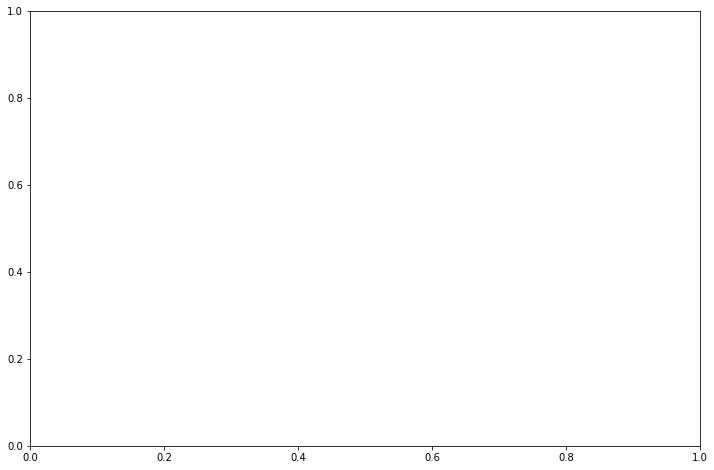

In [5]:
#@title Confution Matrix and Classification Report
#%%capture

#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelBinarizer
num_of_train_samples = 1181
num_of_test_samples = 420

#Load test directory
Pred_Dir = '/content/TestData'
Prediction = ImageDataGenerator(rescale = 1./255)
Pred_Data =  Prediction.flow_from_directory(
                    directory=Pred_Dir,
                    batch_size= batch_size,
                    shuffle=False,
                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                    class_mode=None)

model = load_model('/content/DL_Model.hdf5')
Y_pred = np.round(model.predict(Pred_Data))
y_pred = np.any(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(Pred_Data.classes, y_pred))
print('Classification Report')
target_names = ['Mixed', 'Not Mixed']
#target_names =  list(train_data_gen.class_indices.keys()) #for large number of classes
print(classification_report(Pred_Data.classes, y_pred, target_names=target_names))



# For ROC AND AUC
all_labels = list(train_data_gen.class_indices.keys()) # Two labels in our data
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling

multiclass_roc_auc_score(Pred_Data.classes, y_pred)

In [ ]:
#@title Prediction 
#Prediction
#%%capture

from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

#Make Directory of Kaggle and set its permission for access.
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

# Download Data from Kaggle Fast and Unzip them in /content
!kaggle datasets download -d drswayamprakashpatel/pu-deeplearn  -p /content

#Unzip data (Two Folders - Training and Validation)
import os
os.chdir('/content')
#create a directory named train/
!unzip -q pu-deeplearn.zip

#Make Directories for Test Image Prediction 

!mkdir -p /content/Prediction/Images
files.upload()
!mv *.jpg /content/Prediction/Images


batch_size = 10
IMG_HEIGHT, IMG_WIDTH = (1000,1000)

Pred_Dir = '/content/Test Set'
Prediction = ImageDataGenerator(rescale = 1./255)
Pred_Data =  Prediction.flow_from_directory(
                    directory=Pred_Dir,
                    batch_size= batch_size,
                    shuffle=False,
                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                    class_mode=None)
#Pred_Data.reset()
from keras.models import load_model

#Download Model from Kaggle
!kaggle datasets download -d adddatafilenamehere  -p /content
#Unzip data
import os
os.chdir('/content')
#create a directory named train/
!unzip -q DL_Model.zip

model = load_model('/content/DL_Model.hdf5')
Prediction = np.round(model.predict(Pred_Data))
Prediction = np.any(Prediction, axis=1)



#Multiple images' prediction with image caption

labels = ({'MIXED': 0, 'NOT MIXED': 1})
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in Prediction]
filenames = Pred_Data.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)